# Statistical Analysis - Statistics, Correlations and Regressions

This file is part of the reproduction package provided with the paper Understanding Dark Personality Traits and Strategic Choices in an Inspection Game.

This notebook contains the data analysis presented in the paper, including game behvaior, correlations and regressions. 

Questions and correspondence should be addressed to Vinícius Ferraz (visferraz@gmail.com).

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.formula.api as smf
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import mannwhitneyu
from matplotlib.lines import Line2D

import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

In [9]:
# read pre-processed data
df_full_d = pd.read_csv('data/df_rep_p.csv') # repeated game (70p) dataset
df_rep_r = pd.read_csv('data/repeated_game_raw.csv') # raw repeated game dataset

df_os = pd.read_csv('data/df_os_p.csv') # one-shot game dataset
df_os_r = pd.read_csv('data/oneshot_game_raw.csv') # raw one-shot game

gps_df = pd.read_csv('data/repeated_game_cumprobs.csv') # processed df for the repeated game

sc_df = pd.read_csv('data/strat_changes.csv') # computed strategy changes per player

In [10]:
# splitting data by player
df_f_p1 = df_full_d.loc[df_full_d['player_id']==1]
df_f_p2 = df_full_d.loc[df_full_d['player_id']==2]
df_os_p1 = df_os.loc[df_os['player_type']==1]
df_os_p2 = df_os.loc[df_os['player_type']==2]

# consolidated data (last round of the repeated game)
df_f_lr = df_full_d.loc[df_full_d['round_number']==70]
df_f_p1_lr = df_f_p1[df_f_p1['round_number']==70]
df_f_p2_lr = df_f_p2[df_f_p2['round_number']==70]

In [11]:
# sets of variables for analysis 

dep = ['s1'] # dependent variable - binary occurence of strategy 1 (cheat or control)

# independent variables for the one-shot game dataset
os_ind = ['D-factor','Age', 'Framing', 'Female', 'STEM','Dishonesty Score']

# independent variables for the repeated game dataset
rep_ind = ['D-factor','Age', 'Framing', 'Female', 'STEM', 'Opponent S1 (t-1)', 'Own S1 Freq. (t-1)']
rep_ind_nt = ['D-factor','Age', 'Framing', 'Female', 'STEM']

# independent variable for the rtaliation analysis (repeated game)
rep_ind_ret = ['D-factor','Age', 'Framing', 'Female', 'STEM','Own S1 Freq. (t-1)']

## Samples Information

**Repeated Game Sample**

In [12]:
df_full_d['STEM'].value_counts(normalize=True)

STEM
0    0.68
1    0.32
Name: proportion, dtype: float64

In [13]:
df_full_d['german_nat'].value_counts(normalize=True)

german_nat
0    0.53
1    0.47
Name: proportion, dtype: float64

In [14]:
df_rep_r['gender_str'].value_counts(normalize=True)

gender_str
Female    0.54
Male      0.43
Other     0.02
ND        0.01
Name: proportion, dtype: float64

In [15]:
df_rep_r_lr =  df_rep_r.loc[df_rep_r['round_number']==1]

In [16]:
df_rep_r['gender_str'].value_counts(normalize=True)

gender_str
Female    0.54
Male      0.43
Other     0.02
ND        0.01
Name: proportion, dtype: float64

In [17]:
df_rep_r['age_str'].value_counts(normalize=True)

age_str
18-24    0.54
25-34    0.40
35-44    0.06
Name: proportion, dtype: float64

**One-Shot Game Sample**

In [18]:
df_os['STEM'].value_counts(normalize=True)

STEM
1    0.532319
0    0.467681
Name: proportion, dtype: float64

In [19]:
df_os['german_nat'].value_counts(normalize=True)

german_nat
0    0.589354
1    0.410646
Name: proportion, dtype: float64

In [20]:
df_os_r['gender_str'].value_counts(normalize=True)

gender_str
Female    0.480989
Male      0.471483
ND        0.034221
Other     0.013308
Name: proportion, dtype: float64

In [21]:
df_os_r['age_str'].value_counts(normalize=True)

age_str
18-24                   0.577947
25-34                   0.374525
35-44                   0.028517
I prefer not to say.    0.009506
45-54                   0.005703
Above 54                0.001901
Under 18                0.001901
Name: proportion, dtype: float64

## Statistics

### Statistical tests

**Repeated game:** 

In [22]:
def permutation_test(sample1, sample2, num_permutations=10000, two_tailed=True):
    observed_stat = np.mean(sample1) - np.mean(sample2)
    combined = np.concatenate([sample1, sample2])
    count = 0
    for _ in range(num_permutations):
        np.random.shuffle(combined)
        perm_sample1 = combined[:len(sample1)]
        perm_sample2 = combined[len(sample1):]
        perm_stat = np.mean(perm_sample1) - np.mean(perm_sample2)
        
        if two_tailed:
            if abs(perm_stat) >= abs(observed_stat):
                count += 1
        else:
            if perm_stat >= observed_stat:
                count += 1
    p_value = count / num_permutations
    return p_value, observed_stat

def compare_nonparametric_freqs(sample_1, sample_2):
    
    # Mann-Withney U Test
    U, p_value = mannwhitneyu(sample_1, sample_2, alternative='two-sided')
    direction = "greater" if np.mean(sample_1) > np.mean(sample_2) else "lesser"
    print(f'Mann-Whitney U Test P-value: {p_value}. Sample 1 is {direction} than Sample 2.')
    
    # Permutation Test
    p, observed_stat = permutation_test(sample_1, sample_2, num_permutations=10000, two_tailed=False)
    direction = "greater" if observed_stat > 0 else "lesser"
    print(f"Permutation test P-value: {p}. Sample 1 is {direction} than Sample 2.")

def compare_binomial_samples(sample_1, sample_2):
    
    # Permutation Test
    p, observed_stat = permutation_test(sample_1, sample_2, num_permutations=10000, two_tailed=False)
    direction = "greater" if observed_stat > 0 else "lesser"
    print(f"Permutation test P-value: {p}. Sample 1 is {direction} than Sample 2.")

    # Z-test
    count = np.array([np.sum(sample_1), np.sum(sample_2)]) 
    nobs = np.array([len(sample_1), len(sample_2)])     
    z, p = proportions_ztest(count, nobs)
    direction = "greater" if z > 0 else "lesser"
    print(f"Z-test P-value: {p}. Sample 1 is {direction} than Sample 2.")

    # Fisher's Exact Test
    contingency_table = [[len(sample_1) - np.sum(sample_1), len(sample_2) - np.sum(sample_2)],
                         [np.sum(sample_1), np.sum(sample_2)]]
    _, p = stats.fisher_exact(contingency_table)
  
    print(f"Fisher's Exact Test P-value: {p}")


Test 1 - framed treatment vs. unframed treatment

In [23]:
sample_1 = df_f_lr['s1_freq'][df_f_lr['framed'] == 1] # framed treatment
sample_2 = df_f_lr['s1_freq'][df_f_lr['framed'] == 0] # unframed treatment
print('Game:')
compare_nonparametric_freqs(sample_1, sample_2)

Game:
Mann-Whitney U Test P-value: 0.6138330108155987. Sample 1 is greater than Sample 2.
Permutation test P-value: 0.0883. Sample 1 is greater than Sample 2.


Test 2 - males vs. females

In [24]:
sample_1 = df_f_lr['s1_freq'][df_f_lr['gender'] == 1] # male
sample_2 = df_f_lr['s1_freq'][df_f_lr['gender'] == 2] # female
compare_nonparametric_freqs(sample_1, sample_2)

Mann-Whitney U Test P-value: 0.9044477643545787. Sample 1 is greater than Sample 2.
Permutation test P-value: 0.299. Sample 1 is greater than Sample 2.


Test 3 - inspector framed vs. inspector unframed

In [25]:
sample_1 = df_f_p1_lr['s1_freq'][df_f_p1_lr['framed'] == 1]
sample_2 = df_f_p1_lr['s1_freq'][df_f_p1_lr['framed'] == 0]
compare_nonparametric_freqs(sample_1, sample_2)

Mann-Whitney U Test P-value: 0.2557154184995717. Sample 1 is greater than Sample 2.
Permutation test P-value: 0.0819. Sample 1 is greater than Sample 2.


Test 4 - student framed vs. student unframed

In [26]:
sample_1 = df_f_p2_lr['s1_freq'][df_f_p2_lr['framed'] == 1]
sample_2 = df_f_p2_lr['s1_freq'][df_f_p2_lr['framed'] == 0]
compare_nonparametric_freqs(sample_1, sample_2)

Mann-Whitney U Test P-value: 0.9454902718414993. Sample 1 is greater than Sample 2.
Permutation test P-value: 0.2506. Sample 1 is greater than Sample 2.


**One-shot game:** 

Test 1 - framed treatment vs. unframed treatment

In [27]:
sample_1 = df_os['s1'][df_os['Framing'] == 1] # framed treatment
sample_2 = df_os['s1'][df_os['Framing'] == 0] # unframed treatment
compare_binomial_samples(sample_1, sample_2)

Permutation test P-value: 0.1399. Sample 1 is greater than Sample 2.
Z-test P-value: 0.23851585442084677. Sample 1 is greater than Sample 2.
Fisher's Exact Test P-value: 0.2422631439687751


Test 2 - males vs. females

In [28]:
sample_1 = df_os['s1'][df_os['Female'] == 0] # Male
samplex_2 = df_os['s1'][df_os['Female'] == 1] # Female
compare_binomial_samples(sample_1, sample_2)

Permutation test P-value: 0.3189. Sample 1 is greater than Sample 2.
Z-test P-value: 0.5777344690549433. Sample 1 is greater than Sample 2.
Fisher's Exact Test P-value: 0.5857391624563038


Test 3 - inspector framed vs. inspector unframed

In [29]:
sample_1 = df_os_p1['s1'][df_os_p1['Framing'] == 1] 
sample_2 = df_os_p1['s1'][df_os_p1['Framing'] == 0] 
compare_binomial_samples(sample_1, sample_2)

Permutation test P-value: 0.0016. Sample 1 is greater than Sample 2.
Z-test P-value: 0.0032147954191925794. Sample 1 is greater than Sample 2.
Fisher's Exact Test P-value: 0.004263260430193554


Test 4 - student framed vs. student unframed

In [30]:
sample_1 = df_os_p2['s1'][df_os_p2['Framing'] == 1] 
sample_2 = df_os_p2['s1'][df_os_p2['Framing'] == 0] 
compare_binomial_samples(sample_1, sample_2)

Permutation test P-value: 0.9189. Sample 1 is lesser than Sample 2.
Z-test P-value: 0.21959956974336114. Sample 1 is lesser than Sample 2.
Fisher's Exact Test P-value: 0.2626357800204652


### Game Behavior

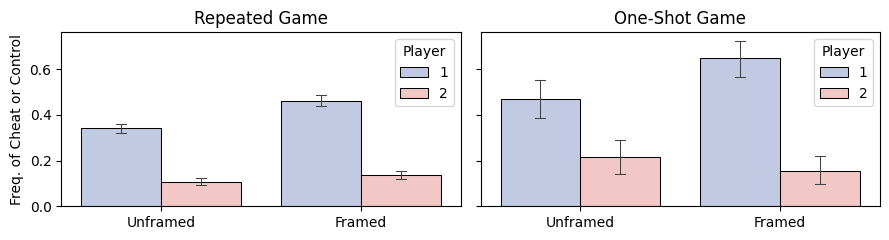

In [37]:
data_rep_fr = df_full_d.loc[df_full_d['Framing']==1]
data_rep_uf = df_full_d.loc[df_full_d['Framing']==0]

palette=['#BCC8E7', '#F8C2BE']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 2.5), sharex=True, sharey=True)

sns.barplot(ax = ax1, data=df_full_d, x="Framing", y="s1", hue='player_id', palette=palette, 
            edgecolor='black', capsize=.05, linewidth = .75)

for line in ax1.lines:  
    line.set_linewidth(0.75)  
    
ax1.set_title('Repeated Game')
ax1.set_xlabel("")
ax1.set_ylabel("Freq. of Cheat or Control")
ax1.legend_.set_title("Player")
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Unframed', 'Framed'])

sns.barplot(ax = ax2, data=df_os, x="Framing", y="s1", hue='player_type', palette=palette, 
            edgecolor='black', capsize=.05, linewidth = .75)
for line in ax2.lines: 
    line.set_linewidth(0.75) 

ax2.set_title('One-Shot Game')
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.legend_.set_title("Player")
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Unframed', 'Framed'])

plt.tight_layout()
plt.savefig('mean_freqs.png', dpi=300)

**Repeated Game Analysis**

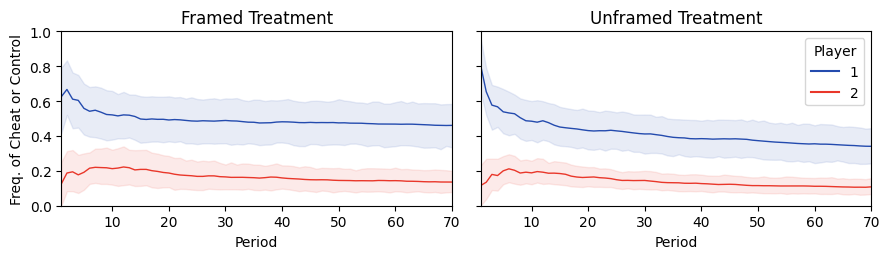

In [39]:
data_rep_fr = df_full_d.loc[df_full_d['Framing']==1]
data_rep_uf = df_full_d.loc[df_full_d['Framing']==0]

palette=['#244BAE', '#E9372A']

x_lim = (1, 70)
y_lim = (0, 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 2.7), sharex=True, sharey=True)

# Plot for data_fr
sns.lineplot(ax=ax1, data=data_rep_fr, x='round_number', y='s1_freq', palette=palette,
             hue='player_id',err_kws={"alpha": .1}, linewidth = 1)
ax1.set_title('Framed Treatment')
ax1.set_xlabel("Period")
ax1.set_ylabel("Freq. of Cheat or Control")
ax1.set_ylim(y_lim)
ax1.set_xlim(x_lim)
ax1.get_legend().set_visible(False)

# Plot for data_uf
sns.lineplot(ax=ax2, data=data_rep_uf, x='round_number', y='s1_freq', palette=palette,
             hue='player_id',err_kws={"alpha": .1}, linewidth = 1)
ax2.set_title('Unframed Treatment')
ax2.set_xlabel("Period")
ax2.set_ylim(y_lim)
ax2.set_xlim(x_lim)
ax2.legend_.set_title("Player")

plt.tight_layout()
plt.savefig('plot2.png', dpi=300)

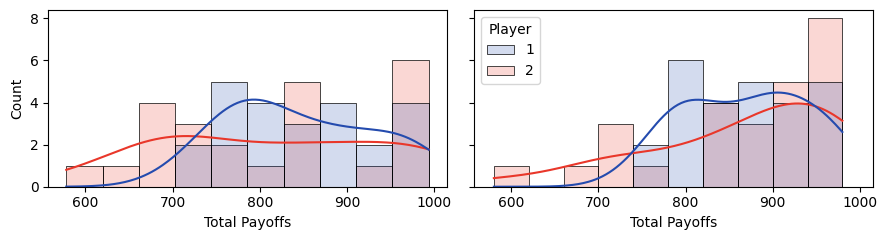

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 2.5), sharex=True, sharey=True)

# Data preparation based on the 'Framing' variable
df_f_lr_f = df_f_lr.loc[df_f_lr['Framing'] == 1]
df_f_lr_u = df_f_lr.loc[df_f_lr['Framing'] == 0]

# Define a palette for colors
palette = ['#244BAE', '#E9372A']


# Plot for data_fr
sns.histplot(ax=ax1, data=df_f_lr_f, x='player_total_payoff', hue='player_id', kde=True,
             palette=palette, alpha=0.2, linewidth=0.5, bins=10)
ax1.set_xlabel("Total Payoffs")
ax1.get_legend().set_visible(False)
#annotate_mean(ax1, df_f_lr_f)

# Plot for data_uf
sns.histplot(ax=ax2, data=df_f_lr_u, x='player_total_payoff', hue='player_id', kde=True,
             palette=palette, alpha=0.2, linewidth=0.5, bins=10)
ax2.set_xlabel("Total Payoffs")
ax2.legend_.set_title("Player")
#annotate_mean(ax2, df_f_lr_u)
plt.tight_layout()

In [34]:
# Mapping dictionary
player_id_map = {
    1: 'Inspector',
    2: 'Student'
}

# Create new column
df_f_lr_f['role'] = df_f_lr_f['player_id'].map(player_id_map)
df_f_lr_u['role'] = df_f_lr_u['player_id'].map(player_id_map)

/var/folders/wy/4467m_9j6p702lhjqwf4zqhm0000gp/T/ipykernel_15290/2676107271.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f_lr_f['role'] = df_f_lr_f['player_id'].map(player_id_map)
/var/folders/wy/4467m_9j6p702lhjqwf4zqhm0000gp/T/ipykernel_15290/2676107271.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f_lr_u['role'] = df_f_lr_u['player_id'].map(player_id_map)


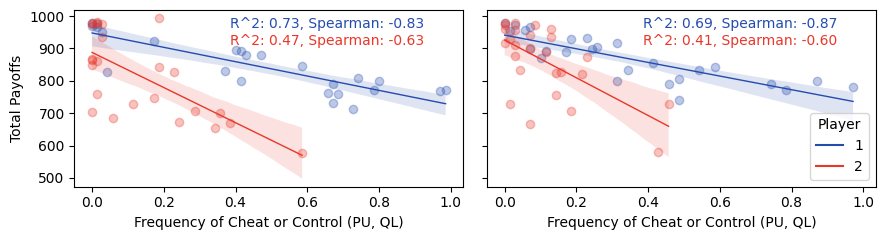

In [36]:
# Create a 1x2 grid of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 2.5), sharex=True, sharey=True)


# Common function for annotation
def annotate(ax, data):
    for player_id, color in zip([1, 2], ['#244BAE', '#E9372A']):
        player_data = data[data['player_id'] == player_id]
        r_value = stats.linregress(player_data['s1_freq'], player_data['player_total_payoff']).rvalue
        spearman_corr = stats.spearmanr(player_data['s1_freq'], player_data['player_total_payoff']).correlation
        ax.annotate(f"R^2: {r_value**2:.2f}, Spearman: {spearman_corr:.2f}",
                    xy=(0.4, 0.9 if player_id == 1 else 0.8), xycoords='axes fraction', color=color)

# Plotting for Framed
sns.regplot(ax=ax1, data=df_f_lr_f[df_f_lr_f['player_id'] == 1], x='s1_freq', y='player_total_payoff',
            color='#244BAE', scatter_kws={'alpha': 0.3}, line_kws={'linewidth': 1})
sns.regplot(ax=ax1, data=df_f_lr_f[df_f_lr_f['player_id'] == 2], x='s1_freq', y='player_total_payoff',
            color='#E9372A', scatter_kws={'alpha': 0.3}, line_kws={'linewidth': 1})
annotate(ax1, df_f_lr_f)
ax1.set_ylabel("Total Payoffs")
ax1.set_xlabel("Frequency of Cheat or Control (PU, QL)")

# Plotting for Unframed
sns.regplot(ax=ax2, data=df_f_lr_u[df_f_lr_u['player_id'] == 1], x='s1_freq', y='player_total_payoff',
            color='#244BAE', scatter_kws={'alpha': 0.3}, line_kws={'linewidth': 1})
sns.regplot(ax=ax2, data=df_f_lr_u[df_f_lr_u['player_id'] == 2], x='s1_freq', y='player_total_payoff',
            color='#E9372A', scatter_kws={'alpha': 0.3}, line_kws={'linewidth': 1})
annotate(ax2, df_f_lr_u)
ax2.set_xlabel("Frequency of Cheat or Control (PU, QL)")

# Additional settings for each subplot
for ax in [ax1, ax2]:
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='#244BAE', label='1'),
                   Line2D([0], [0], color='#E9372A', label='2')]
ax2.legend(handles=legend_elements, title='Player', loc='lower right')
ax2.yaxis.label.set_visible(False)

plt.tight_layout()
plt.savefig('plot.png', dpi=300)

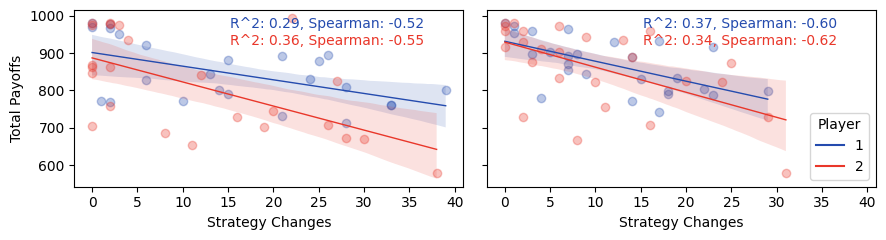

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 2.5), sharex=True, sharey=True)

#
sc_fr = sc_df.loc[sc_df['Framing'] == 1]
sc_uf = sc_df.loc[sc_df['Framing'] == 0]

# Annotation
def annotate(ax, data):
    for player_id, color in zip([1, 2], ['#244BAE', '#E9372A']):
        player_data = data[data['player_id'] == player_id]
        r_value = stats.linregress(player_data['strategy_changes'], player_data['player_total_payoff']).rvalue
        spearman_corr = stats.spearmanr(player_data['strategy_changes'], 
                                        player_data['player_total_payoff']).correlation
        ax.annotate(f"R^2: {r_value**2:.2f}, Spearman: {spearman_corr:.2f}",
                    xy=(0.4, 0.9 if player_id == 1 else 0.8), xycoords='axes fraction', color=color)

# Plotting for Framed
sns.regplot(ax=ax1, data=sc_fr[sc_fr['player_id'] == 1], x='strategy_changes', y='player_total_payoff',
            color='#244BAE', scatter_kws={'alpha': 0.3}, line_kws={'linewidth': 1})
sns.regplot(ax=ax1, data=sc_fr[sc_fr['player_id'] == 2], x='strategy_changes', y='player_total_payoff',
            color='#E9372A', scatter_kws={'alpha': 0.3}, line_kws={'linewidth': 1})
annotate(ax1, sc_fr)
ax1.set_ylabel("Total Payoffs")
ax1.set_xlabel("Strategy Changes")

# Plotting for Unframed
sns.regplot(ax=ax2, data=sc_uf[sc_uf['player_id'] == 1], x='strategy_changes', y='player_total_payoff',
            color='#244BAE', scatter_kws={'alpha': 0.3}, line_kws={'linewidth': 1})
sns.regplot(ax=ax2, data=sc_uf[sc_uf['player_id'] == 2], x='strategy_changes', y='player_total_payoff',
            color='#E9372A', scatter_kws={'alpha': 0.3}, line_kws={'linewidth': 1})
annotate(ax2, sc_uf)
ax2.set_xlabel("Strategy Changes")

# Additional settings for each subplot
for ax in [ax1, ax2]:
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)


legend_elements = [Line2D([0], [0], color='#244BAE', label='1'),
                   Line2D([0], [0], color='#E9372A', label='2')]
ax2.legend(handles=legend_elements, title='Player', loc='lower right')
ax2.yaxis.label.set_visible(False)

# Add legend manually
plt.tight_layout()


**One-Shot Game Analysis**

In [41]:
matched_players_list = []

for framing in [0, 1]:
    df1 = df_os[(df_os['player_type'] == 1) & (df_os['Framing'] == framing)].reset_index()
    df2 = df_os[(df_os['player_type'] == 2) & (df_os['Framing'] == framing)].reset_index()

    df1 = df1.sample(frac=1).reset_index(drop=True)
    df2 = df2.sample(frac=1).reset_index(drop=True)
    n_pairs = min(len(df1), len(df2))

    for i in range(n_pairs):
        s1 = df1.loc[i, 'strategy']
        s2 = df2.loc[i, 'strategy']
        
        if s1 == 1 and s2 == 1:
            p1_payoff, p2_payoff = 12, 2
        elif s1 == 1 and s2 == 2:
            p1_payoff, p2_payoff = 11, 10
        elif s1 == 2 and s2 == 1:
            p1_payoff, p2_payoff = 3, 16
        elif s1 == 2 and s2 == 2:
            p1_payoff, p2_payoff = 14, 14
        
        matched_players_list.append({
            'player1_code': df1.loc[i, 'lfdn'],
            'player2_code': df2.loc[i, 'lfdn'],
            'Framing': framing,
            'player1_strategy': s1,
            'player2_strategy': s2,
            'player1_payoff': p1_payoff,
            'player2_payoff': p2_payoff
        })

matched_players = pd.DataFrame(matched_players_list)
matched_players['pair_id'] = range(1, len(matched_players) + 1)

player1_df = matched_players[['player1_code', 'Framing', 'player1_strategy', 'player1_payoff']].copy()
player2_df = matched_players[['player2_code', 'Framing', 'player2_strategy', 'player2_payoff']].copy()

player1_df['player_id'] = 1
player2_df['player_id'] = 2

player1_df.columns = ['player_code', 'Framing', 'strategy', 'payoff', 'player_id']
player2_df.columns = ['player_code', 'Framing', 'strategy', 'payoff', 'player_id']


matched_tabular = pd.concat([player1_df, player2_df], axis=0).reset_index(drop=True)

matched_tabular = matched_tabular.sort_values(['player_code'])
matched_tabular = matched_tabular.reset_index()

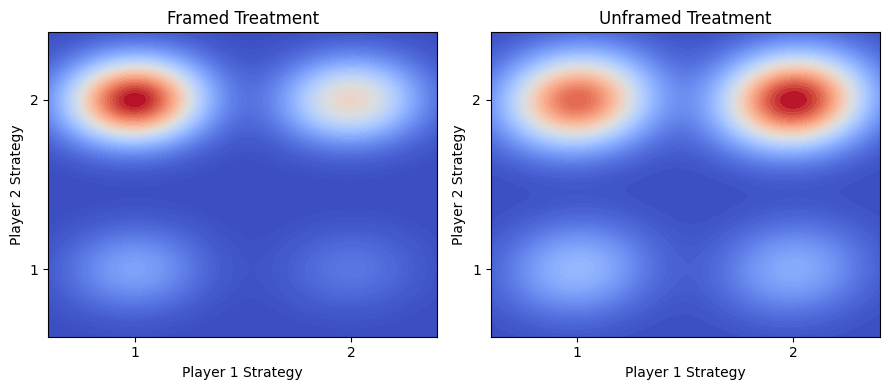

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), sharey=False)

# Plotting KDE for Framed
sns.kdeplot(x='player1_strategy', y='player2_strategy', fill=True,
            data=matched_players[matched_players['Framing'] == 1], ax=ax1, thresh=0, levels=70, cmap="coolwarm")
ax1.set_title('Framed Treatment')
ax1.set_xticks([1, 2])
ax1.set_yticks([1, 2])
ax1.set_xlim([0.6, 2.4])
ax1.set_ylim([0.6, 2.4])
ax1.set_xlabel('Player 1 Strategy')
ax1.set_ylabel('Player 2 Strategy')

# Plotting KDE for Unframed
sns.kdeplot(x='player1_strategy', y='player2_strategy', fill=True,
            data=matched_players[matched_players['Framing'] == 0], ax=ax2, thresh=0, levels=70, cmap="coolwarm")
ax2.set_title('Unframed Treatment')
ax2.set_xticks([1, 2])
ax2.set_yticks([1, 2])
ax2.set_xlim([0.6, 2.4])
ax2.set_ylim([0.6, 2.4])
ax2.set_xlabel('Player 1 Strategy')
ax2.set_ylabel('Player 2 Strategy')

plt.tight_layout()

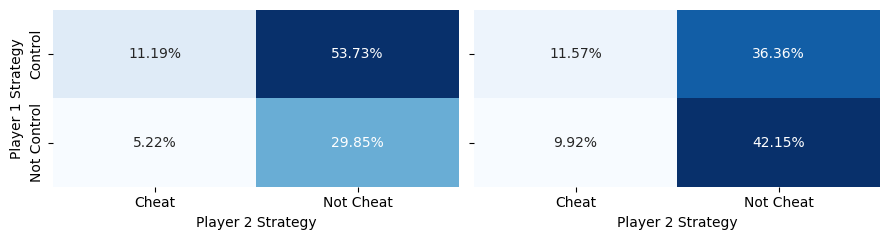

In [56]:
def create_frequency_table(df, framing):
    # Filter for the framing condition
    df_framed = df[df['Framing'] == framing]
    
    # Create the frequency table
    frequency_table = pd.crosstab(df_framed['player1_strategy'], df_framed['player2_strategy'])
    
    # Normalize the frequencies
    frequency_table = frequency_table / frequency_table.sum().sum()
    
    return frequency_table

# Assuming 'matched_players' is defined
# matched_players = ...

# Apply the function for each framing condition
frequency_table_framed = create_frequency_table(matched_players, 1)
frequency_table_unframed = create_frequency_table(matched_players, 0)

# Rename the indices and columns to reflect the actual strategies
index_names = {1: 'Control', 2: 'Not Control'}
column_names = {1: 'Cheat', 2: 'Not Cheat'}

frequency_table_framed = frequency_table_framed.rename(index=index_names, columns=column_names)
frequency_table_unframed = frequency_table_unframed.rename(index=index_names, columns=column_names)

# Create the heatmap side by side
fig, axs = plt.subplots(1, 2, figsize=(9, 2.5), sharey=True)

sns.heatmap(frequency_table_framed, annot=True, fmt='.2%', cmap="Blues", ax=axs[0], cbar=False)
axs[0].set_title('')
axs[0].set_xlabel('Player 2 Strategy')
axs[0].set_ylabel('Player 1 Strategy')

sns.heatmap(frequency_table_unframed, annot=True, fmt='.2%', cmap="Blues", ax=axs[1], cbar=False)
axs[1].set_title('')
axs[1].set_xlabel('Player 2 Strategy')
axs[1].set_ylabel('')

plt.tight_layout()
plt.savefig('stratmat.png', dpi=300)

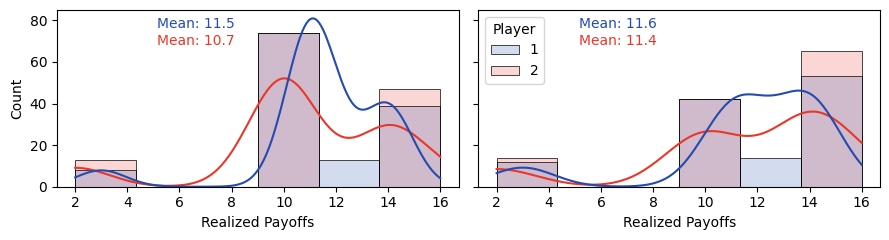

In [37]:
# Function to annotate mean total payoff for each player
def annotate_mean(ax, data):
    for player_id, color in zip([1, 2], palette):
        mean_payoff = data[data['player_id'] == player_id]['payoff'].mean()
        ax.annotate(f"Mean: {mean_payoff:.1f}", 
                    xy=(0.25, 0.9 if player_id == 1 else 0.8), 
                    xycoords='axes fraction', color=color)

# Your existing plot code
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 2.5), sharex=True, sharey=True)

# Data preparation based on the 'Framing' variable
df_mp_f = matched_tabular.loc[matched_tabular['Framing'] == 1]
df_mp_u = matched_tabular.loc[matched_tabular['Framing'] == 0]

# Define a palette for colors
palette = ['#244BAE', '#E9372A']

# Plot for framed data
sns.histplot(ax=ax1, data=df_mp_f, x='payoff', hue='player_id', kde=True,
             palette=palette, alpha=0.2, linewidth=0.5, bins=6)
ax1.set_xlabel("Realized Payoffs")
ax1.get_legend().set_visible(False)
annotate_mean(ax1, df_mp_f)  # Call the function to annotate mean for the first subplot

# Plot for unframed data
sns.histplot(ax=ax2, data=df_mp_u, x='payoff', hue='player_id', kde=True,
             palette=palette, alpha=0.2, linewidth=0.5, bins=6)
ax2.set_xlabel("Realized Payoffs")
ax2.legend_.set_title("Player")
annotate_mean(ax2, df_mp_u)  # Call the function to annotate mean for the second subplot

plt.tight_layout()


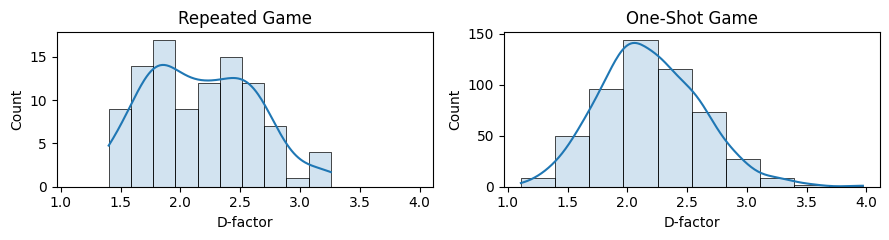

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 2.5), sharex=True)

# Data preparation based on the 'Framing' variable
df_f_lr_f = df_f_lr.loc[df_f_lr['Framing'] == 1]
df_f_lr_u = df_f_lr.loc[df_f_lr['Framing'] == 0]

# Define a palette for colors
palette = ['#244BAE', '#E9372A']


# Plot for data_fr
sns.histplot(ax=ax1, data=df_f_lr, x='D-factor', kde=True,
             alpha=0.2, linewidth=0.5, bins=10)
#ax1.set_xlabel("Total Payoffs")
ax1.set_title('Repeated Game')
#annotate_mean(ax1, df_f_lr_f)

# Plot for data_uf
sns.histplot(ax=ax2, data=df_os, x='D-factor', kde=True,
             alpha=0.2, linewidth=0.5, bins=10)
#ax2.set_xlabel("D-Factor")
ax2.set_title('One-Shot Game')
#annotate_mean(ax2, df_f_lr_u)

plt.tight_layout()

**Strategy Differences - Repeated Game**

In [39]:
def print_percentage(df, player_id, framed_value, column_framed, colum_player):
    percentage = df['s1'][(df[colum_player] == player_id) & (df[column_framed] == framed_value)].mean() * 100
    framing = "framed" if framed_value else "unframed"
    print(f"Percentage of s1=1 for player {player_id} when {framing}: {percentage:.2f}%")
    return percentage

In [40]:
perc_p1_framed = print_percentage(df_full_d, 1, 1, 'framed', 'player_id')
perc_p1_unframed = print_percentage(df_full_d, 1, 0, 'framed', 'player_id')
perc_p2_framed = print_percentage(df_full_d, 2, 1, 'framed', 'player_id')
perc_p2_unframed = print_percentage(df_full_d, 2, 0, 'framed', 'player_id')
diff_p1 = perc_p1_framed - perc_p1_unframed
diff_p2 = perc_p2_framed - perc_p2_unframed
print(f"\nPercentage difference for player 1: {diff_p1:.2f}%")
print(f"Percentage difference for player 2: {diff_p2:.2f}%")

Percentage of s1=1 for player 1 when framed: 46.07%
Percentage of s1=1 for player 1 when unframed: 34.07%
Percentage of s1=1 for player 2 when framed: 13.57%
Percentage of s1=1 for player 2 when unframed: 10.82%

Percentage difference for player 1: 12.01%
Percentage difference for player 2: 2.75%


**Strategy Differences - One-Shot Game**

In [70]:
perc_p1_framed = print_percentage(df_os, 1, 1, 'Framing', 'player_type')
perc_p1_unframed = print_percentage(df_os, 1, 0, 'Framing', 'player_type')
perc_p2_framed = print_percentage(df_os, 2, 1, 'Framing', 'player_type')
perc_p2_unframed = print_percentage(df_os, 2, 0, 'Framing', 'player_type')
diff_p1 = perc_p1_framed - perc_p1_unframed
diff_p2 = perc_p2_framed - perc_p2_unframed
print(f"\nPercentage difference for player 1: {diff_p1:.2f}%")
print(f"Percentage difference for player 2: {diff_p2:.2f}%")

Percentage of s1=1 for player 1 when framed: 64.93%
Percentage of s1=1 for player 1 when unframed: 46.92%
Percentage of s1=1 for player 2 when framed: 15.60%
Percentage of s1=1 for player 2 when unframed: 21.49%

Percentage difference for player 1: 18.00%
Percentage difference for player 2: -5.88%


### Retaliation Analysis

In [71]:
grouped_df = df_full_d[df_full_d['round_number'] <= 70].groupby(['participant_code', 
                                                                 'player_id','gender', 'framed']).agg({
    'p1s1_change': 'sum',
    'p2s1_change': 'sum',
    'react_possible_p1': 'sum',
    'react_possible_p2': 'sum'
}).reset_index()

grouped_df['react'] = np.where(grouped_df['player_id'] == 1, 
                              grouped_df['p1s1_change'] / grouped_df['react_possible_p1'], 
                              grouped_df['p2s1_change'] / grouped_df['react_possible_p2'])

grouped_df = grouped_df.fillna(0)

In [72]:
sample_1 = grouped_df['react'][grouped_df['framed'] == 1]
sample_2 = grouped_df['react'][grouped_df['framed'] == 0] 

sample_3 = grouped_df['react'][grouped_df['gender'] == 1]
sample_4 = grouped_df['react'][grouped_df['gender'] == 2] 

sample_5 = grouped_df['react'][grouped_df['player_id'] == 1]
sample_6 = grouped_df['react'][grouped_df['player_id'] == 2] 

print('Framing:')
compare_nonparametric_freqs(sample_1, sample_2)
print('----')
print('Gender:')
compare_nonparametric_freqs(sample_3, sample_4)
print('----')
print('Player:')
compare_nonparametric_freqs(sample_5, sample_6)

Framing:
Mann-Whitney U Test P-value: 0.3417539008012783. Sample 1 is lesser than Sample 2.
Permutation test P-value: 0.6653. Sample 1 is lesser than Sample 2.
----
Gender:
Mann-Whitney U Test P-value: 0.8686709281355289. Sample 1 is lesser than Sample 2.
Permutation test P-value: 0.6513. Sample 1 is lesser than Sample 2.
----
Player:
Mann-Whitney U Test P-value: 0.0007145005938369996. Sample 1 is greater than Sample 2.
Permutation test P-value: 0.0. Sample 1 is greater than Sample 2.


#### Aggregated Frequencies

In [73]:
# Grpup data by treamtent
grouped = df_full_d.groupby('framed').agg({'p1s1_change': 'sum', 'p2s1_change': 'sum',
                                           'react_possible_p1': 'sum', 'react_possible_p2': 'sum'})

# Calculate reaction frequency relative to reaction opportunities
grouped['p1_react'] = grouped['p1s1_change'] / grouped['react_possible_p1']
grouped['p2_react'] = grouped['p2s1_change'] / grouped['react_possible_p2']
print('Frequency by Treatment:')
print(grouped[['p1_react', 'p2_react']])

Frequency by Treatment:
        p1_react  p2_react
framed                    
0       0.603093  0.146580
1       0.649123  0.166884


In [74]:
grouped['p1_react']

framed
0    0.603093
1    0.649123
Name: p1_react, dtype: float64

In [75]:
# Grpup data by gender
grouped = df_full_d.groupby('gender').agg({'p1s1_change': 'sum', 'p2s1_change': 'sum',
                                           'react_possible_p1': 'sum', 'react_possible_p2': 'sum'})

# Calculate reaction frequency relative to reaction opportunities
grouped['p1_react'] = grouped['p1s1_change'] / grouped['react_possible_p1']
grouped['p2_react'] = grouped['p2s1_change'] / grouped['react_possible_p2']
print('Frequency by Treatment:')
print(grouped[['p1_react', 'p2_react']])
# 1 = male, 2 = female

Frequency by Treatment:
        p1_react  p2_react
gender                    
1       0.611465  0.203552
2       0.640152  0.108150
3            NaN  0.000000
4       0.000000       NaN


### Correlation Analysis

In [76]:
alpha = 0.5 # significance level

def calculate_correlation(df_name, binary_var, numerical_vars):
    binary_var = df_name[binary_var].values.ravel()
    correlation_results = []
    for var in numerical_vars.columns:
        corr, p_value = pointbiserialr(binary_var, df_name[var].values)
        correlation_results.append({'Variable': var, 'Correlation': corr, 'P-value': p_value})
    correlation_df = pd.DataFrame(correlation_results)
    correlation_df = correlation_df.sort_values('Correlation', ascending=False)
    correlation_df['significance'] = np.where(correlation_df['P-value'] < alpha, 'significant', 'not_significant')
    return correlation_df

def plot_time_series_correlations(dfs, titles, dependent_var, independent_vars):
    correlations_dfs = []
    for df in dfs:
        correlations = []
        for round_nr in df['round_number'].unique():
            for ind in independent_vars:
                corr = df[df['round_number'] == round_nr][[dependent_var, ind]].corr(method='spearman').iloc[0, 1]
                correlations.append({'round_number': round_nr, 'variable': ind, 'correlation': corr})

        correlations_df = pd.DataFrame(correlations)
        correlations_dfs.append(correlations_df)
        
    fig, axes = plt.subplots(1, len(dfs), figsize=(18, 4), sharex=True)
    for i, (correlations, title) in enumerate(zip(correlations_dfs, titles)):
        sns.lineplot(data=correlations, x='round_number', y='correlation', hue='variable', ax=axes[i])
        axes[i].set_title(title)
        if i != 0:
            axes[i].get_legend().remove()
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

    plt.tight_layout()

In [77]:
pbs_all = calculate_correlation(df_full_d, dep, df_full_d[rep_ind])
pbs_p1 = calculate_correlation(df_f_p1, dep, df_f_p1[rep_ind])
pbs_p2 = calculate_correlation(df_f_p2, dep, df_f_p2[rep_ind])
pbs_all_os = calculate_correlation(df_os, dep, df_os[os_ind])
pbs_p1_os = calculate_correlation(df_os_p1, dep, df_os_p1[os_ind])
pbs_p2_os = calculate_correlation(df_os_p2, dep, df_os_p2[os_ind])

#### Point-Biserial Correlations with Strategy 1 (cheat or control) - Repeated Game

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True)

sns.barplot(data=pbs_all, y='Variable', x='Correlation', ax=axes[0], hue = 'significance', 
            edgecolor='grey',dodge=False)

sns.barplot(data=pbs_p1, y='Variable', x='Correlation', ax=axes[1], hue = 'significance',
            edgecolor='grey',dodge=False)

sns.barplot(data=pbs_p2, y='Variable', x='Correlation', ax=axes[2], hue = 'significance',
            edgecolor='grey',dodge=False)

axes[0].set_title('Game 70p')
axes[1].set_title('Player 1 (inspector) 70p')
axes[2].set_title('Player 2 (student) 70p')
plt.tight_layout()  

#### Point-Biserial Correlations with Strategy 1 (cheat or control) - One-Shot Game

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True) 

sns.barplot(data=pbs_all_os, y='Variable', x='Correlation', ax=axes[0], hue = 'significance', 
            edgecolor='grey',dodge=False)

sns.barplot(data=pbs_p1_os, y='Variable', x='Correlation', ax=axes[1], hue = 'significance', 
            edgecolor='grey',dodge=False)

sns.barplot(data=pbs_p2_os, y='Variable', x='Correlation', ax=axes[2], hue = 'significance', 
            edgecolor='grey',dodge=False)

axes[0].set_title('Game 70p')
axes[1].set_title('Player 1 (inspector) 70p')
axes[2].set_title('Player 2 (student) 70p') 
plt.tight_layout()  

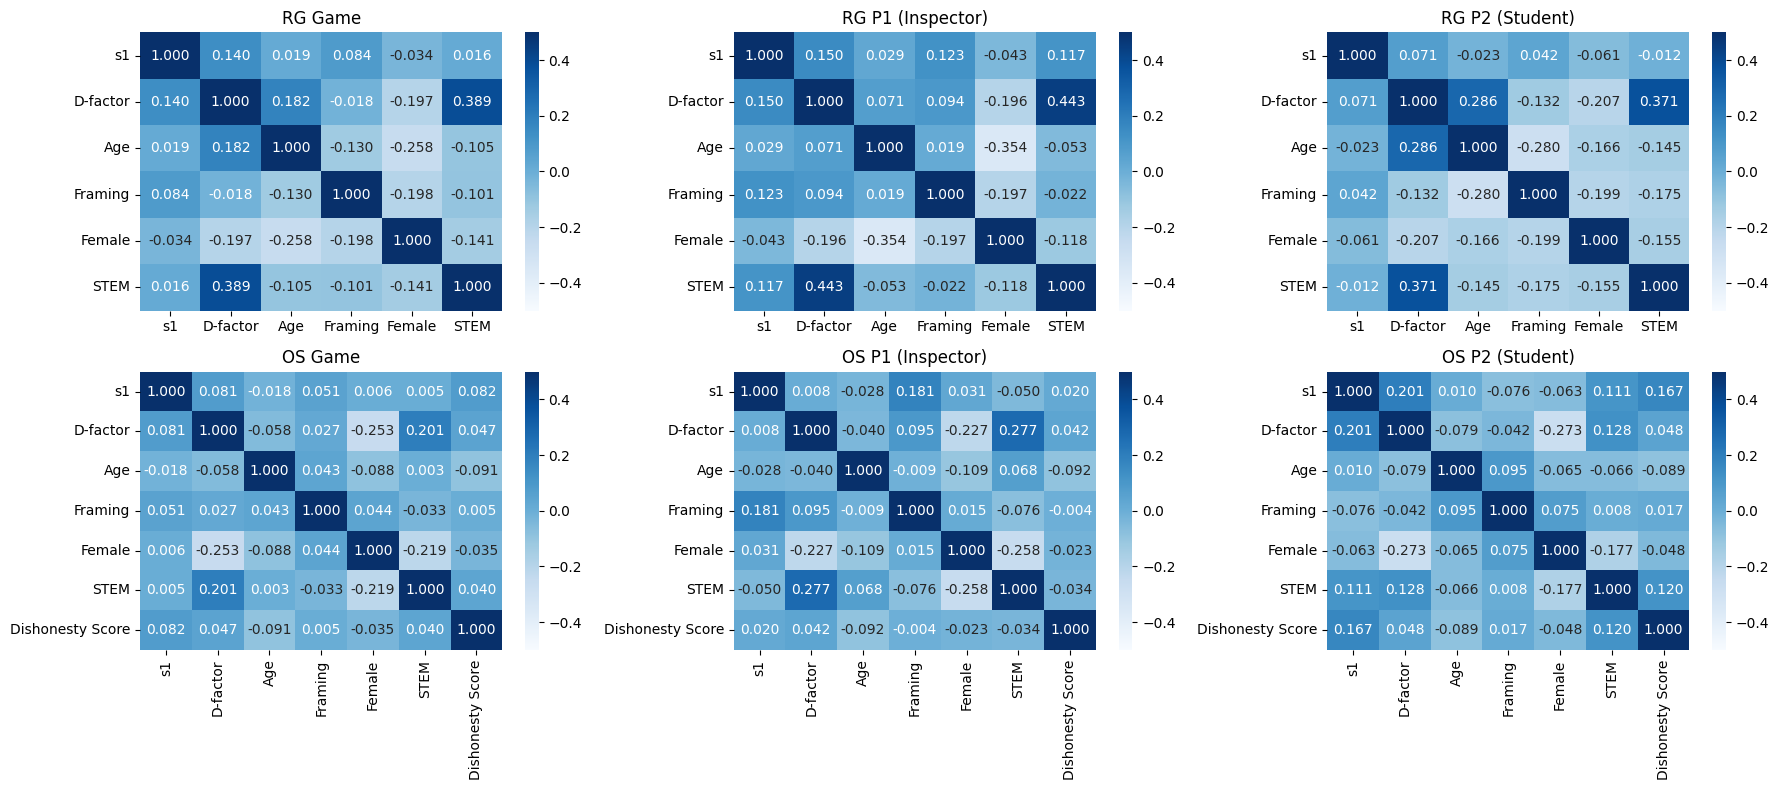

In [126]:
def plot_correlation_grid(dataframes, cmap, titles, corr_vars_list):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))
    
    for ax, df, title, corr_vars in zip(axes.ravel(), dataframes, titles, corr_vars_list):
        corr_vars = dep + corr_vars
        correlation_mat = df[corr_vars].corr(method='spearman')
        sns.heatmap(correlation_mat, annot=True, cmap=cmap, vmin=-0.5, vmax=0.5, fmt=".3f", ax=ax)
        ax.set_title(title)
    
    plt.tight_layout()

dataframes_list = [df_full_d, df_f_p1, df_f_p2, df_os, df_os_p1, df_os_p2] 
titles_list = ["RG Game", "RG P1 (Inspector)", "RG P2 (Student)", "OS Game", "OS P1 (Inspector)", "OS P2 (Student)"]

corr_vars_list = [rep_ind_nt, rep_ind_nt, rep_ind_nt, os_ind, os_ind, os_ind]

plot_correlation_grid(dataframes_list, 'Blues', titles_list, corr_vars_list)


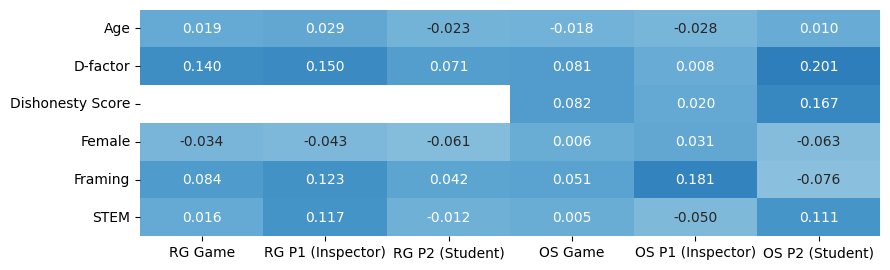

In [151]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create an empty list to store the correlation dataframes
correlation_dfs = []

# Define the order in which dataframes should be processed
order = [0, 1, 2, 3, 4, 5]  # This order assumes "RG" dataframes come first

# Iterate through dataframes and their corresponding independent variables
for idx in order:
    df = dataframes_list[idx]
    title = titles_list[idx]
    corr_vars = corr_vars_list[idx]
    
    for var in corr_vars:
        # Calculate Spearman correlation
        correlation = df[['s1', var]].corr(method='spearman').iloc[0, 1]
        # Create a dataframe to store the correlation result
        corr_df = pd.DataFrame({'Variable': [var], 'Dataset': [title], 'Spearman Correlation': [correlation]})
        # Append the result to the list
        correlation_dfs.append(corr_df)

# Combine all correlation dataframes into one
correlation_df = pd.concat(correlation_dfs, ignore_index=True)

# Pivot the correlation_df to create the table
pivot_table = correlation_df.pivot_table(index=['Variable'], columns=['Dataset'], values='Spearman Correlation')

# Reorder the columns to have "FULL" dataframes first and "OS" dataframes second
column_order = ['RG Game', 'RG P1 (Inspector)', 'RG P2 (Student)', 'OS Game', 'OS P1 (Inspector)', 'OS P2 (Student)']
pivot_table = pivot_table[column_order]

# Plot the table with variable names (axes titles)
plt.figure(figsize=(9.2, 3))
sns.heatmap(pivot_table, annot=True, cmap='Blues', vmin=-0.5, vmax=0.5, fmt=".3f", 
            cbar=False, xticklabels=True, yticklabels=True)
plt.title('')
plt.tight_layout()
plt.xlabel('')  # Remove x-axis label
plt.ylabel('')  # Remove y-axis label


### Regression Models

In [37]:
def compute_vif(df, variables):
    X = sm.add_constant(df[variables])
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

In [40]:
vif_rep = compute_vif(df_full_d, rep_ind)
vif_ps = compute_vif(df_os, os_ind)

In [41]:
vif_rep

,Variable,VIF
0,const,49.202152
1,D-factor,1.329197
2,Age,1.209209
3,Framing,1.126674
4,Female,1.183024
5,STEM,1.332519
6,Opponent S1 (t-1),1.031596
7,Own S1 Freq. (t-1),1.039049


In [42]:
vif_ps

,Variable,VIF
0,const,58.806845
1,D-factor,1.103629
2,Age,1.032155
3,Framing,1.007498
4,Female,1.110808
5,STEM,1.074125
6,Dishonesty Score,1.016119


In [43]:
# some helper functions 

def get_significance(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return 'o'

def plot_logistic_coefficients(logit_result, ax):
    df_log = pd.DataFrame({'coefficient': logit_result.params.values,
                           'p': logit_result.pvalues})
    df_log = df_log.sort_values(by='coefficient', ascending=False)
    df_log = df_log.reset_index(level=0)
    df_log['significance'] = df_log['p'].apply(get_significance)

    sig_order = ['***', '**', '*', 'o']
    palette = {'***': 'mediumspringgreen',
               '**': 'c',
               '*': 'deepskyblue',
               'o': 'lightgrey'}

    sns.barplot(x='coefficient', y='index', data=df_log, hue='significance',
                hue_order=sig_order, dodge=False, palette=palette, edgecolor='black', linewidth=0.5, ax=ax)

    ax.set_title('Logistic Coefficients')
    ax.set_xlabel('Coefficient')
    ax.set_ylabel('')
    ax.legend(title='Significance')
    
    pseudo_r2 = logit_result.prsquared
    ax.text(0.95, 0.05, 'Pseudo R2: {:.2f}'.format(pseudo_r2),
            transform=ax.transAxes, horizontalalignment='right', verticalalignment='bottom')

def fit_logit_model(X, y, cluster_var=None):
    X = sm.add_constant(X)
    logit_model = sm.Logit(y, X)
    if cluster_var is not None:
        logit_result = logit_model.fit(cov_type='cluster', cov_kwds={'groups': cluster_var})
    else:
        logit_result = logit_model.fit()
    return logit_result

In [44]:
cluster_var_a = df_full_d['participant_code']
cluster_var_p1 = df_f_p1['participant_code']
cluster_var_p2 = df_f_p2['participant_code']

In [45]:
df_f_p1['participant_code'].nunique()

50

In [46]:
# fitting several regression models 
logit_result_all = fit_logit_model(df_full_d[rep_ind], df_full_d[dep], cluster_var_a)
logit_result_p1 = fit_logit_model(df_f_p1[rep_ind], df_f_p1[dep], cluster_var_p1)
logit_result_p2 = fit_logit_model(df_f_p2[rep_ind], df_f_p2[dep], cluster_var_p2)

logit_result_all_os = fit_logit_model(df_os[os_ind], df_os[dep])
logit_result_p1_os = fit_logit_model(df_os_p1[os_ind], df_os_p1[dep])
logit_result_p2_os = fit_logit_model(df_os_p2[os_ind], df_os_p2[dep])

model_ret_p1 = fit_logit_model(df_f_p1[rep_ind_ret], df_f_p1['p1s1_change'], cluster_var_p1)
model_ret_p2 = fit_logit_model(df_f_p2[rep_ind_ret], df_f_p2['p2s1_change'], cluster_var_p2)

Optimization terminated successfully.
         Current function value: 0.404791
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481188
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.310070
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.668117
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.434324
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.251043
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.176577
         Iterations 8


#### Logistic Regression Models - Repeated Game

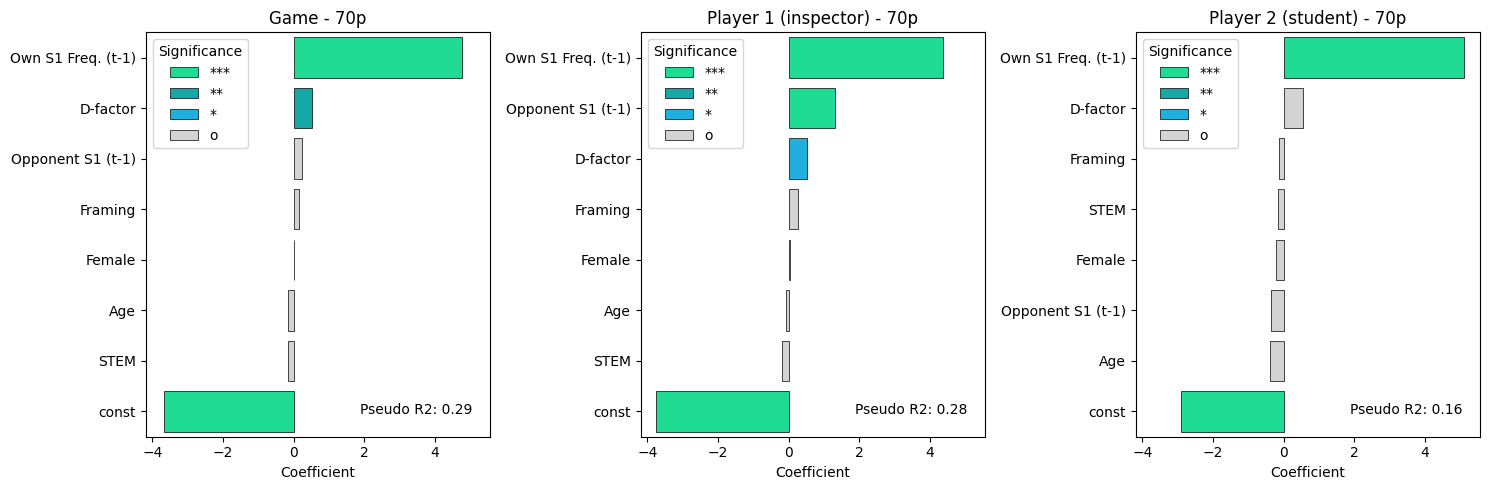

In [62]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

plot_logistic_coefficients(logit_result_all, ax=axes[0])
axes[0].set_title('Game - 70p')
plot_logistic_coefficients(logit_result_p1, ax=axes[1])
axes[1].set_title('Player 1 (inspector) - 70p')
plot_logistic_coefficients(logit_result_p2, ax=axes[2])
axes[2].set_title('Player 2 (student) - 70p')
plt.tight_layout()

#### Logistic Regression Models , Retaliation (binary) - Repeated Game

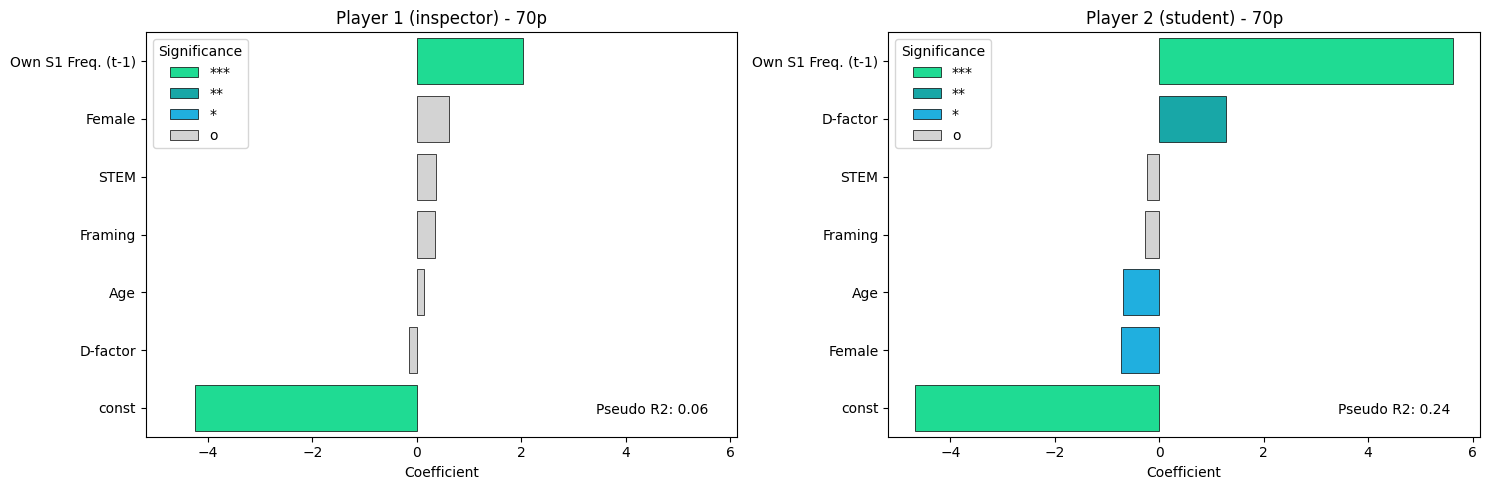

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
plot_logistic_coefficients(model_ret_p1, ax=axes[0])
axes[0].set_title('Player 1 (inspector) - 70p')
plot_logistic_coefficients(model_ret_p2, ax=axes[1])
axes[1].set_title('Player 2 (student) - 70p')
plt.tight_layout()

### One-shot regression models

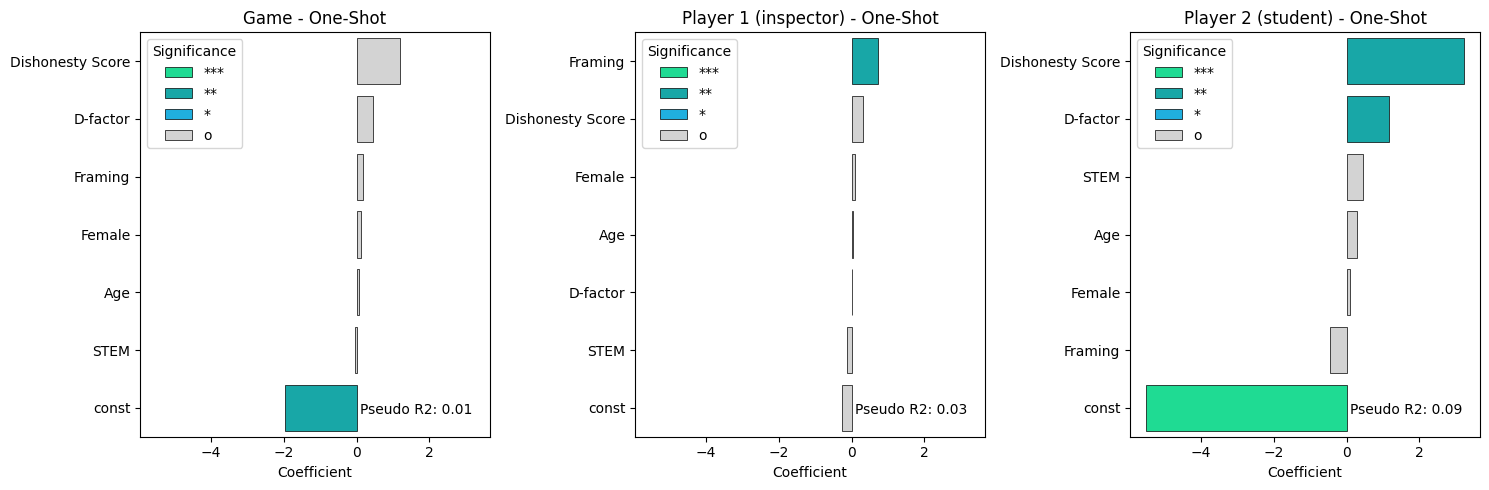

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

plot_logistic_coefficients(logit_result_all_os, ax=axes[0])
axes[0].set_title('Game - One-Shot')
plot_logistic_coefficients(logit_result_p1_os, ax=axes[1])
axes[1].set_title('Player 1 (inspector) - One-Shot')
plot_logistic_coefficients(logit_result_p2_os, ax=axes[2])
axes[2].set_title('Player 2 (student) - One-Shot')
plt.tight_layout()